## Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gzip
import gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
import time
import re
import pickle
import math
from scipy.spatial.distance import cosine as sp_cosine
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine

## Load company reviews from pickle file:

In [2]:
reviews= pd.read_pickle('./reviews_pickle_company.pkl')

In [3]:
reviews.head(4)

,Ticker Symbol,PROs,CONs,company
0,nyse:t,Great people to work with. Benefits are great.,Constant pressure to hit unattainable numbers ...,AT&T Inc
1,nyse:t,"Flexible schedule, great management team, PTO ...",I currently do not have any cons,AT&T Inc
2,nyse:t,Amazing pay for a company that is so huge and ...,Management is always changing which leads to h...,AT&T Inc
3,nyse:t,"Benefits, compensation, management, my positio...",Way too much red tape...to be expected for a c...,AT&T Inc


## Defining some useful functions:

### Selecting one company:

In [4]:
def selection_company(company_name):
    'Returns a dataframe containing only Company named company_name'
    # select the instances in the column 'company' where it equals company_name:
    company=reviews[reviews['company']==company_name]
    return company

### Selecting positive or negative reviews:

In [5]:
def selecting_polarity(company_name,polarity):
    'Returns a dataframe containing reviews as chosen in the parameter polarity\
      for Company named company_name. The parameter polarity has to\
      be either "pros" to select positive reviews or "cons" to select negative reviews'
    if polarity == 'pros':
        company_polarity= selection_company(company_name)[['PROs']].astype('str')
    else:
        company_polarity= selection_company(company_name)[['CONs']].astype('str')
    return company_polarity

## Processing reviews (remove stopwords and short words, all lower and no symbols):

### Processing function:

In [6]:
def preprocess(text):
    '''This functions processes the input 'text' by removing stopwords, short words
        and symbols, returning a list with its processed contents comma separated.'''
    processed_text = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            processed_text.append(token)
    return processed_text

### Processing function applied to dataframe:

In [7]:
def processed(company_name,polarity):
    'Returns a series containing processed reviews as chosen in the parameter polarity\
      for Company named company_name. The parameter polarity has to\
      be either "pros" to select positive reviews or "cons" to select negative reviews'
    chosen_company=reviews[reviews['company']==company_name].astype('str')
    if polarity == 'pros':
        processed_series = chosen_company['PROs'].map(preprocess)
    else:
        processed_series = chosen_company['CONs'].map(preprocess)
    return processed_series

## Loading glove:

In [8]:
dic_name='glove_dir'
dict_object=open(dic_name,'rb')
embeddings_index2=pickle.load(dict_object)

## Cosine similarity:

In [9]:
def cosin_similarity(v1, v2):
    return 1.0 - sp_cosine(v1, v2) 

## I choose cosin_similarity.

## Transforming reviews to vectors:
#### In this case we will construct a vector for the value, then a vector for each word of the review, calculate the similarity and keep the maximum similarity for each review. The output is a list containing the maximum similarity for each review.

In [10]:
def reviews_to_vectors_max_overlap2(company,polarity,value):
    '''Returns a list of values containing the maximum cosine similarity value between 
    the input value "value" and each review of polarity "polarity", which has to be either
    "pros" or "cons", of the input Company "company_name"'''
    processed_series=processed(company_name,polarity) # store processed series
    value_vector=embeddings_index2[value] # vector for the input value
    max_overlaps_vector=[] # this list will contain maximum value of cosine similarity between value and each review
    for i in range(len(processed_series)): # one pass for each review
        overlap_vector=[] # this list will contain values of cosine similarity between value and each word in the review
        for token in processed_series.iloc[i]: # one pass for each word in processed review
            try:
                token_embedding = embeddings_index2[token] # returns vector for given word
                if not np.isnan(token_embedding).any():
                    overlap_vector.append(cosin_similarity(value_vector,token_embedding)) #calculates cosine similarity between the value and each word in the review
            except KeyError: #ignores reviews with misspellings
                pass    
        if len(overlap_vector) > 0:
            max_overlaps_vector.append(np.max(overlap_vector)) # selects maximum cosine similarity and appends it to list
        else:
            max_overlaps_vector.append(0) # in case the review is empty
    return max_overlaps_vector

In [111]:
%lprun -f reviews_to_vectors_max_overlap2 reviews_to_vectors_max_overlap2("Royal Bank of Canada","pros","salary") #check for bottlenecks

## Counting the number of reviews where cosine similarity is above a threshold:

In [11]:
def count_polarity(company_name,polarity,value,threshold):
    '''Returns the number of reviews with polarity "polarity" for Company "company_name"
        where the cosine similarity for value "value" is above "threshold"'''
    series_count_polarity = pd.Series(reviews_to_vectors_max_overlap2(company_name,polarity,value)) #converts list into a series
    number_of_counts = series_count_polarity[series_count_polarity >= threshold].count() #counts reviews above a threshold
    return number_of_counts

## Calculating the score in percentage:

In [12]:
def percentage_polarity(company_name,polarity,value,threshold):
    '''Returns the score between 0 to 100% of Company "company_name" for value "value"
        and polarity "polarity" for a given input "threshold"'''
    series_count_polarity = pd.Series(reviews_to_vectors_max_overlap2(company_name,polarity,value)) #converts list into a series
    number_of_counts = series_count_polarity[series_count_polarity >= threshold].count() #counts reviews above a threshold
    polarity_percentage = 100*number_of_counts/len(series_count_polarity) #score in percentage is calculated
    return polarity_percentage

## Select list of companies and values to precompute scores:

In [13]:
precomputed_companies_list = ['AT&T Inc','Wal-Mart Stores','Nordstrom','Suncor Energy Inc','Wells Fargo & Company',
                              'SAP Ag', 'Capital One Financial Corp', 'Fedex Corp','Citigroup Inc', 'Target Corp',
                              'JP Morgan Chase & CO', 'Thomson Reuters Corp', 'Coca-Cola Company', 'Yelp Inc',
                              'Motorola Solutions', 'Spotify Technology S.A.', 'Morgan Stanley', 'Booz Allen Hamilton Holding Corp',
                              'Bank of Montreal','Pfizer Inc', 'Shopify Inc', 'Best Buy CO', 'Goldman Sachs Group',
                              'Accenture Plc','HSBC Holdings Plc', 'Bank of America Corp', 'Walt Disney Company',
                              'Exxon Mobil Corp', 'CGI Group','Manulife Financial Corp','Visa Inc', 'Boeing Company',
                              'AON Plc', 'Equifax Inc', 'Metlife Inc', 'Deutsche Bank Ag', 'Toronto Dominion Bank',
                              'Kellogg Company', 'CBS Corp', 'Blackberry Ltd', 'General Electric Company',
                              'Procter & Gamble Company', '3M Company', 'Unilever NV', 'American Express Company',
                              'Credit Suisse Group', 'Square', 'Twitter Inc', 'Sun Life Financial Inc', 
                              'Royal Bank of Canada', 'Bank of Nova Scotia', 'Avon Products','Sony Corp', 'Loews Corp',
                              'Mastercard Inc', 'National Bank Holdings Corp', 'Rogers Communication', 
                              'Canadian Imperial Bank of Commerce', 'Fitbit Inc']
precomputed_values_list = ['compensation', 'flexibility', 'location', 'vacations', 'vacation', 'team', 'size',
                          'structure', 'balance', 'environment', 'holidays', 'money', 'people', 'growth',
                          'prestige', 'established', 'name', 'boss', 'pay', 'size', 'culture', 'location',
                          'impact', 'innovation', 'research', 'benefits', 'pension', 'insurance', 'medical',
                          'facilities', 'gym','parking', 'training', 'development', 'growth', 'mobility', 
                          'hierarchy', 'mission', 'management', 'politics', 'opportunities', 'polocies',
                          'friendliness', 'projects', 'challenging', 'product', 'learn', 'pace', 'employee',
                          'employees']
polarities_list = ['pros','cons']

## Precomputing scores:

In [61]:
precomputed_results_percentage = {} #define new dictionary where scores will be stored
for value_ in precomputed_values_list:
    print(value_) #to keep track
    for company_ in precomputed_companies_list:
        print(company_) #to keep track
        for polarity_ in polarities_list:
            print(polarity_) #to keep track
            precomputed_results_percentage[value_, company_,polarity_] = \
                percentage_polarity(company_,polarity_,value_,0.6)

compensation
AT&T Inc
pros
cons
Wal-Mart Stores
pros
cons
Nordstrom
pros
cons
Suncor Energy Inc
pros
cons
Wells Fargo & Company
pros
cons
SAP Ag
pros
cons
Capital One Financial Corp
pros
cons
Fedex Corp
pros
cons
Citigroup Inc
pros
cons
Target Corp
pros
cons
JP Morgan Chase & CO
pros
cons
Thomson Reuters Corp
pros
cons
Coca-Cola Company
pros
cons
Yelp Inc
pros
cons
Motorola Solutions
pros
cons
Spotify Technology S.A.
pros
cons
Morgan Stanley
pros
cons
Booz Allen Hamilton Holding Corp
pros
cons
Bank of Montreal
pros
cons
Pfizer Inc
pros
cons
Shopify Inc
pros
cons
Best Buy CO
pros
cons
Goldman Sachs Group
pros
cons
Accenture Plc
pros
cons
HSBC Holdings Plc
pros
cons
Bank of America Corp
pros
cons
Walt Disney Company
pros
cons
Exxon Mobil Corp
pros
cons
CGI Group
pros
cons
Manulife Financial Corp
pros
cons
Visa Inc
pros
cons
Boeing Company
pros
cons
AON Plc
pros
cons
Equifax Inc
pros
cons
Metlife Inc
pros
cons
Deutsche Bank Ag
pros
cons
Toronto Dominion Bank
pros
cons
Kellogg Company
pros

cons
Thomson Reuters Corp
pros
cons
Coca-Cola Company
pros
cons
Yelp Inc
pros
cons
Motorola Solutions
pros
cons
Spotify Technology S.A.
pros
cons
Morgan Stanley
pros
cons
Booz Allen Hamilton Holding Corp
pros
cons
Bank of Montreal
pros
cons
Pfizer Inc
pros
cons
Shopify Inc
pros
cons
Best Buy CO
pros
cons
Goldman Sachs Group
pros
cons
Accenture Plc
pros
cons
HSBC Holdings Plc
pros
cons
Bank of America Corp
pros
cons
Walt Disney Company
pros
cons
Exxon Mobil Corp
pros
cons
CGI Group
pros
cons
Manulife Financial Corp
pros
cons
Visa Inc
pros
cons
Boeing Company
pros
cons
AON Plc
pros
cons
Equifax Inc
pros
cons
Metlife Inc
pros
cons
Deutsche Bank Ag
pros
cons
Toronto Dominion Bank
pros
cons
Kellogg Company
pros
cons
CBS Corp
pros
cons
Blackberry Ltd
pros
cons
General Electric Company
pros
cons
Procter & Gamble Company
pros
cons
3M Company
pros
cons
Unilever NV
pros
cons
American Express Company
pros
cons
Credit Suisse Group
pros
cons
Square
pros
cons
Twitter Inc
pros
cons
Sun Life Financial

Best Buy CO
pros
cons
Goldman Sachs Group
pros
cons
Accenture Plc
pros
cons
HSBC Holdings Plc
pros
cons
Bank of America Corp
pros
cons
Walt Disney Company
pros
cons
Exxon Mobil Corp
pros
cons
CGI Group
pros
cons
Manulife Financial Corp
pros
cons
Visa Inc
pros
cons
Boeing Company
pros
cons
AON Plc
pros
cons
Equifax Inc
pros
cons
Metlife Inc
pros
cons
Deutsche Bank Ag
pros
cons
Toronto Dominion Bank
pros
cons
Kellogg Company
pros
cons
CBS Corp
pros
cons
Blackberry Ltd
pros
cons
General Electric Company
pros
cons
Procter & Gamble Company
pros
cons
3M Company
pros
cons
Unilever NV
pros
cons
American Express Company
pros
cons
Credit Suisse Group
pros
cons
Square
pros
cons
Twitter Inc
pros
cons
Sun Life Financial Inc
pros
cons
Royal Bank of Canada
pros
cons
Bank of Nova Scotia
pros
cons
Avon Products
pros
cons
Sony Corp
pros
cons
Loews Corp
pros
cons
Mastercard Inc
pros
cons
National Bank Holdings Corp
pros
cons
Rogers Communication
pros
cons
Canadian Imperial Bank of Commerce
pros
cons
Fitb

AON Plc
pros
cons
Equifax Inc
pros
cons
Metlife Inc
pros
cons
Deutsche Bank Ag
pros
cons
Toronto Dominion Bank
pros
cons
Kellogg Company
pros
cons
CBS Corp
pros
cons
Blackberry Ltd
pros
cons
General Electric Company
pros
cons
Procter & Gamble Company
pros
cons
3M Company
pros
cons
Unilever NV
pros
cons
American Express Company
pros
cons
Credit Suisse Group
pros
cons
Square
pros
cons
Twitter Inc
pros
cons
Sun Life Financial Inc
pros
cons
Royal Bank of Canada
pros
cons
Bank of Nova Scotia
pros
cons
Avon Products
pros
cons
Sony Corp
pros
cons
Loews Corp
pros
cons
Mastercard Inc
pros
cons
National Bank Holdings Corp
pros
cons
Rogers Communication
pros
cons
Canadian Imperial Bank of Commerce
pros
cons
Fitbit Inc
pros
cons
name
AT&T Inc
pros
cons
Wal-Mart Stores
pros
cons
Nordstrom
pros
cons
Suncor Energy Inc
pros
cons
Wells Fargo & Company
pros
cons
SAP Ag
pros
cons
Capital One Financial Corp
pros
cons
Fedex Corp
pros
cons
Citigroup Inc
pros
cons
Target Corp
pros
cons
JP Morgan Chase & CO
p

American Express Company
pros
cons
Credit Suisse Group
pros
cons
Square
pros
cons
Twitter Inc
pros
cons
Sun Life Financial Inc
pros
cons
Royal Bank of Canada
pros
cons
Bank of Nova Scotia
pros
cons
Avon Products
pros
cons
Sony Corp
pros
cons
Loews Corp
pros
cons
Mastercard Inc
pros
cons
National Bank Holdings Corp
pros
cons
Rogers Communication
pros
cons
Canadian Imperial Bank of Commerce
pros
cons
Fitbit Inc
pros
cons
location
AT&T Inc
pros
cons
Wal-Mart Stores
pros
cons
Nordstrom
pros
cons
Suncor Energy Inc
pros
cons
Wells Fargo & Company
pros
cons
SAP Ag
pros
cons
Capital One Financial Corp
pros
cons
Fedex Corp
pros
cons
Citigroup Inc
pros
cons
Target Corp
pros
cons
JP Morgan Chase & CO
pros
cons
Thomson Reuters Corp
pros
cons
Coca-Cola Company
pros
cons
Yelp Inc
pros
cons
Motorola Solutions
pros
cons
Spotify Technology S.A.
pros
cons
Morgan Stanley
pros
cons
Booz Allen Hamilton Holding Corp
pros
cons
Bank of Montreal
pros
cons
Pfizer Inc
pros
cons
Shopify Inc
pros
cons
Best Buy CO


cons
National Bank Holdings Corp
pros
cons
Rogers Communication
pros
cons
Canadian Imperial Bank of Commerce
pros
cons
Fitbit Inc
pros
cons
pension
AT&T Inc
pros
cons
Wal-Mart Stores
pros
cons
Nordstrom
pros
cons
Suncor Energy Inc
pros
cons
Wells Fargo & Company
pros
cons
SAP Ag
pros
cons
Capital One Financial Corp
pros
cons
Fedex Corp
pros
cons
Citigroup Inc
pros
cons
Target Corp
pros
cons
JP Morgan Chase & CO
pros
cons
Thomson Reuters Corp
pros
cons
Coca-Cola Company
pros
cons
Yelp Inc
pros
cons
Motorola Solutions
pros
cons
Spotify Technology S.A.
pros
cons
Morgan Stanley
pros
cons
Booz Allen Hamilton Holding Corp
pros
cons
Bank of Montreal
pros
cons
Pfizer Inc
pros
cons
Shopify Inc
pros
cons
Best Buy CO
pros
cons
Goldman Sachs Group
pros
cons
Accenture Plc
pros
cons
HSBC Holdings Plc
pros
cons
Bank of America Corp
pros
cons
Walt Disney Company
pros
cons
Exxon Mobil Corp
pros
cons
CGI Group
pros
cons
Manulife Financial Corp
pros
cons
Visa Inc
pros
cons
Boeing Company
pros
cons
AON Pl

Capital One Financial Corp
pros
cons
Fedex Corp
pros
cons
Citigroup Inc
pros
cons
Target Corp
pros
cons
JP Morgan Chase & CO
pros
cons
Thomson Reuters Corp
pros
cons
Coca-Cola Company
pros
cons
Yelp Inc
pros
cons
Motorola Solutions
pros
cons
Spotify Technology S.A.
pros
cons
Morgan Stanley
pros
cons
Booz Allen Hamilton Holding Corp
pros
cons
Bank of Montreal
pros
cons
Pfizer Inc
pros
cons
Shopify Inc
pros
cons
Best Buy CO
pros
cons
Goldman Sachs Group
pros
cons
Accenture Plc
pros
cons
HSBC Holdings Plc
pros
cons
Bank of America Corp
pros
cons
Walt Disney Company
pros
cons
Exxon Mobil Corp
pros
cons
CGI Group
pros
cons
Manulife Financial Corp
pros
cons
Visa Inc
pros
cons
Boeing Company
pros
cons
AON Plc
pros
cons
Equifax Inc
pros
cons
Metlife Inc
pros
cons
Deutsche Bank Ag
pros
cons
Toronto Dominion Bank
pros
cons
Kellogg Company
pros
cons
CBS Corp
pros
cons
Blackberry Ltd
pros
cons
General Electric Company
pros
cons
Procter & Gamble Company
pros
cons
3M Company
pros
cons
Unilever NV
pr

cons
Booz Allen Hamilton Holding Corp
pros
cons
Bank of Montreal
pros
cons
Pfizer Inc
pros
cons
Shopify Inc
pros
cons
Best Buy CO
pros
cons
Goldman Sachs Group
pros
cons
Accenture Plc
pros
cons
HSBC Holdings Plc
pros
cons
Bank of America Corp
pros
cons
Walt Disney Company
pros
cons
Exxon Mobil Corp
pros
cons
CGI Group
pros
cons
Manulife Financial Corp
pros
cons
Visa Inc
pros
cons
Boeing Company
pros
cons
AON Plc
pros
cons
Equifax Inc
pros
cons
Metlife Inc
pros
cons
Deutsche Bank Ag
pros
cons
Toronto Dominion Bank
pros
cons
Kellogg Company
pros
cons
CBS Corp
pros
cons
Blackberry Ltd
pros
cons
General Electric Company
pros
cons
Procter & Gamble Company
pros
cons
3M Company
pros
cons
Unilever NV
pros
cons
American Express Company
pros
cons
Credit Suisse Group
pros
cons
Square
pros
cons
Twitter Inc
pros
cons
Sun Life Financial Inc
pros
cons
Royal Bank of Canada
pros
cons
Bank of Nova Scotia
pros
cons
Avon Products
pros
cons
Sony Corp
pros
cons
Loews Corp
pros
cons
Mastercard Inc
pros
cons


KeyError: 'polocies'

### dump into pickle file:

In [62]:
with open('pre_percentage.pickle', 'wb') as handle:
    pickle.dump(precomputed_results_percentage, handle, protocol=pickle.HIGHEST_PROTOCOL)

### load file:

In [14]:
with open('pre_percentage.pickle', 'rb') as handle:
    pre_percentage_polarity = pickle.load(handle)

In [15]:
 pre_percentage_polarity['balance','Royal Bank of Canada','pros']

50.615961435457955

## Ploting percentage scores:

In [16]:
def percentage_plot(value,company_name): 
    '''Returns Bar Plot of scores for company "company_name" and input "value"'''
    height_pro=pre_percentage_polarity[value, company_name,'pros']
    height_con=pre_percentage_polarity[value, company_name,'cons']
    height=[height_pro,height_con]
    plt.bar(['PROS','CONS'],height,color=[(0.1, 0.7, 0.6, 0.6),(1, 0.3, 0.2, 0.6)])
    plt.ylabel('%')
    plt.title(value)

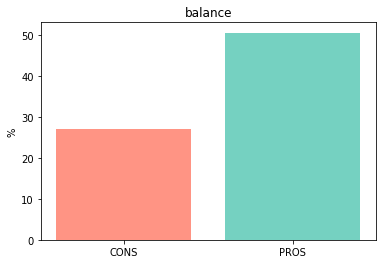

In [17]:
percentage_plot('balance','Royal Bank of Canada')

## Pie plots:

In [18]:
def percentage_plot_pie(value,company_name): 
    '''Returns Pie Plot of scores for company "company_name" and input "value"'''
    height_pro=pre_percentage_polarity[value, company_name,'pros']
    height_con=pre_percentage_polarity[value, company_name,'cons']
    height=[height_pro,height_con,100-(height_pro+height_con)]
    labels=['positive', 'negative','not mentioned']
    pie =plt.pie(height,colors=[(0.1, 0.7, 0.6, 0.5),(1, 0.3, 0.2, 0.5),(.2,.1,.4,.5)],autopct='%1.1f%%')
    plt.axis("image")
    plt.legend(pie[0], labels, bbox_to_anchor=(1,0.5), loc="center right", fontsize=15, 
                          bbox_transform=plt.gcf().transFigure)
    plt.subplots_adjust(left=0.0, bottom=0.1, right=0.45)
    plt.title(value, fontsize=20)

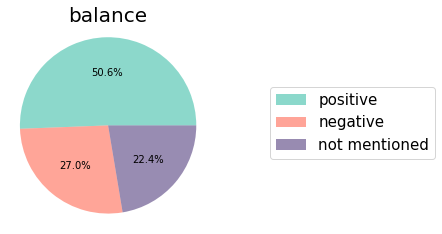

In [19]:
percentage_plot_pie('balance','Royal Bank of Canada')

## Common values:

In [20]:
values_common=['salary','management','culture','balance','team']

## Scores for list of values:

In [21]:
def values_company_score_pro_con(company_name,list_values,threshold):
    score_value_pro=[] #list to store the positive scores
    score_value_con=[] # list to score the negative scores
    for value in list_values:
        score_value_pro.append(pre_percentage_polarity[value, company_name,'pros'])
        score_value_con.append(pre_percentage_polarity[value, company_name,'cons'])
    return score_value_pro,score_value_con

## Precomputing scores for list of values:

In [82]:
precomputed_values_score = {} #define new dictionary where scores will be stored
for company_ in precomputed_companies_list:
    print(company_) # to keep track
    precomputed_values_score[company_] = \
        values_company_score_pro_con(company_,values_common,0.6)

AT&T Inc
Wal-Mart Stores
Nordstrom
Suncor Energy Inc
Wells Fargo & Company
SAP Ag
Capital One Financial Corp
Fedex Corp
Citigroup Inc
Target Corp
JP Morgan Chase & CO
Thomson Reuters Corp
Coca-Cola Company
Yelp Inc
Motorola Solutions
Spotify Technology S.A.
Morgan Stanley
Booz Allen Hamilton Holding Corp
Bank of Montreal
Pfizer Inc
Shopify Inc
Best Buy CO
Goldman Sachs Group
Accenture Plc
HSBC Holdings Plc
Bank of America Corp
Walt Disney Company
Exxon Mobil Corp
CGI Group
Manulife Financial Corp
Visa Inc
Boeing Company
AON Plc
Equifax Inc
Metlife Inc
Deutsche Bank Ag
Toronto Dominion Bank
Kellogg Company
CBS Corp
Blackberry Ltd
General Electric Company
Procter & Gamble Company
3M Company
Unilever NV
American Express Company
Credit Suisse Group
Square
Twitter Inc
Sun Life Financial Inc
Royal Bank of Canada
Bank of Nova Scotia
Avon Products
Sony Corp
Loews Corp
Mastercard Inc
National Bank Holdings Corp
Rogers Communication
Canadian Imperial Bank of Commerce
Fitbit Inc


### dump precomputed scores to pickle file:

In [83]:
with open('pre_scores.pickle', 'wb') as handle:
    pickle.dump(precomputed_values_score, handle, protocol=pickle.HIGHEST_PROTOCOL)

### load from pickle:

In [22]:
with open('pre_scores.pickle', 'rb') as handle:
    pre_values_company_score_pro_con = pickle.load(handle)

## Ploting scores for common values:

In [23]:
def final_plot_pro_con(company_name):
    '''Returns Bar plot with positive and negative scores for Company "company_name" '''
    height_p,height_c=pre_values_company_score_pro_con[company_name] # call scores for company
    N = len(height_p)
    final_height_pro = height_p #positive scores

    ind = np.arange(N)  # the x locations for the groups
    width = 0.4       # the width of the bars

    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(111)
    rects1 = ax.barh(ind, final_height_pro, width, color=(0.1, 0.7, 0.6, 0.6)) #positive scores plot

    final_height_con = height_c # negative scores
    rects2 = ax.barh(ind+width, final_height_con, width, color=(1, 0.3, 0.2, 0.6)) #negative scores plot

    # add some
    ax.set_xlabel('Score %', fontsize=18)
    ax.set_title('Scores by values', fontsize=25)
    ax.set_yticks(ind + width / 2)
    ax.set_yticklabels( values_common, fontsize=18)

    ax.legend( (rects1[0], rects2[0]), ('positive', 'negative'), fontsize=20)

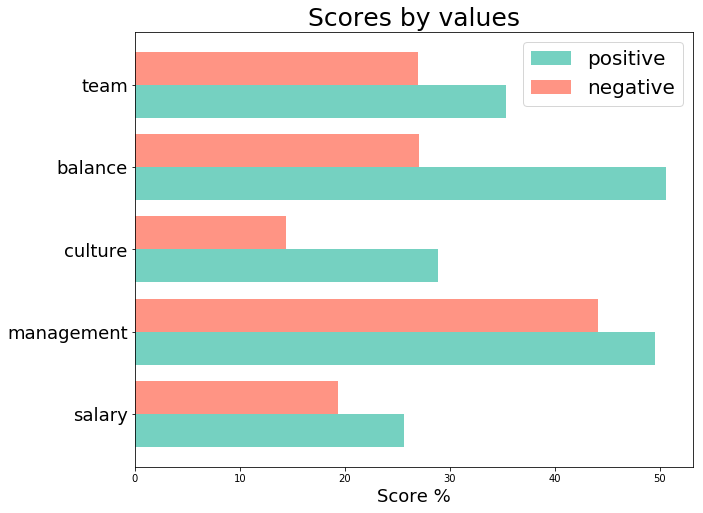

In [24]:
final_plot_pro_con('Royal Bank of Canada')

## Box plot for all companies indicating company of interest in plot:

In [25]:
def box_plot_value(company_name,polarity,value):
    if polarity == 'pros':
        scores_companies_all=[] # list to store score
        value_in_boxplot=pre_percentage_polarity[value, company_name,'pros'] # positive score for company_name
        for company in precomputed_companies_list:
            scores_companies_all.append(pre_percentage_polarity[value, company,'pros']) 
    else:
        scores_companies_all=[]# list to store score
        value_in_boxplot=pre_percentage_polarity[value, company_name,'cons'] # negative score for company_name
        for company in precomputed_companies_list:
            scores_companies_all.append(pre_percentage_polarity[value, company,'cons']) 
        
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(111)
    bp = ax.boxplot(scores_companies_all,patch_artist=True)
    rects2 = ax.scatter(1,value_in_boxplot,color='blue')  

    ax.set_title(value,size=18)
    # annotation of company_name in the plot, indicated by an arrow:
    ax.annotate(company_name,
                size=18,color='black',
            xy=(1, value_in_boxplot), xycoords='data',
            xytext=(0.3, 0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='blue', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')
    # changing colors:
    for box in bp['boxes']:
        box.set( facecolor = (0.1, 0.7, 0.6, 0.2) )

    for median in bp['medians']:
        median.set(color=(0.1, 0.7, 0.6, 0.9), linewidth=2)

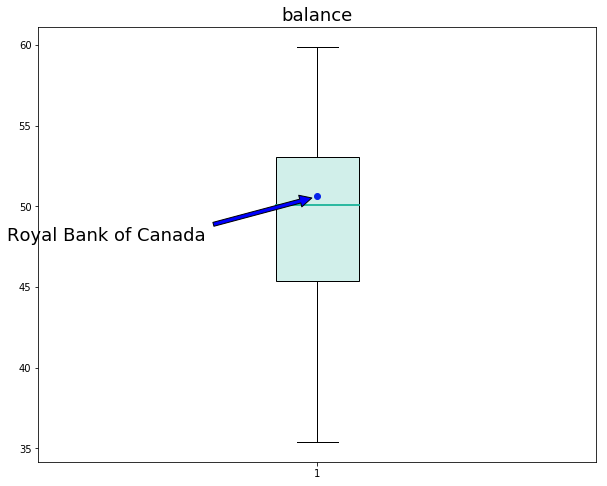

In [26]:
box_plot_value('Royal Bank of Canada','pros','balance')

# Validation of the model:

## Here I convert all scores for the selected companies to a scale of 0 to 5 for the following values: pay, management and culture.

### pay:

In [28]:
score_salary_pro=[]
for company in precomputed_companies_list:
    score_salary_pro.append(pre_percentage_polarity['pay', company, 'pros'])
    score_salary_con=[]
for company in precomputed_companies_list:
    score_salary_con.append(pre_percentage_polarity['pay', company, 'cons'])
score_salary=[]
for i in range(len(score_salary_pro)):
    score_salary.append(5*score_salary_pro[i]/(score_salary_pro[i]+score_salary_con)[i])

### management:

In [29]:
score_management_pro=[]
for company in precomputed_companies_list:
    score_management_pro.append(pre_percentage_polarity['management', company, 'pros'])
    score_management_con=[]
for company in precomputed_companies_list:
    score_management_con.append(pre_percentage_polarity['management', company, 'cons'])
score_management=[]
for i in range(len(score_management_pro)):
    score_management.append(5*score_management_pro[i]/(score_management_pro[i]+score_management_con)[i])

### culture:

In [30]:
score_culture_pro=[]
for company in precomputed_companies_list:
    score_culture_pro.append(pre_percentage_polarity['culture', company, 'pros'])
    score_culture_con=[]
for company in precomputed_companies_list:
    score_culture_con.append(pre_percentage_polarity['culture', company, 'cons'])
score_culture=[]
for i in range(len(score_culture_pro)):
    score_culture.append(5*score_culture_pro[i]/(score_culture_pro[i]+score_culture_con)[i])

## load validation dataframe:

In [102]:
with open('validation_df.pickle', 'rb') as handle:
    validation_df = pickle.load(handle)

In [103]:
validation_df.head()

,Rating: Comp & Benefits,company,Rating: Culture & Values,Rating: Senior Management
0,4.0,AT&T Inc,2.0,2.0
2,4.0,AT&T Inc,4.0,3.0
3,4.0,AT&T Inc,4.0,4.0
4,4.0,AT&T Inc,4.0,4.0
5,4.0,AT&T Inc,4.0,4.0


## Calculate mean score for each company for the following values: salary, management and culture:

In [33]:
mean_review_salary=[]
for company_name in precomputed_companies_list:
    mean_review_salary.append(validation_df[validation_df['company']==company_name].dropna()['Rating: Comp & Benefits'].mean())

In [35]:
mean_review_management=[]
for company_name in precomputed_companies_list:
    mean_review_management.append(validation_df[validation_df['company']==company_name].dropna()['Rating: Senior Management'].mean())

In [36]:
mean_review_culture=[]
for company_name in precomputed_companies_list:
    mean_review_culture.append(validation_df[validation_df['company']==company_name].dropna()['Rating: Culture & Values'].mean())

## Create a dataframe with mean score of Glassdoor reviews and my calculated scores:

In [100]:
scores_df = pd.DataFrame({'UV_management':score_management})
scores_df['UV_salary'] = score_salary
scores_df['UV_culture'] = score_culture
scores_df['glassdoor_management'] = mean_review_management
scores_df['glassdoor_salary'] = mean_review_salary
scores_df['glassdoor_culture'] = mean_review_culture

In [101]:
scores_df.head()

,UV_management,UV_salary,UV_culture,glassdoor_management,glassdoor_salary,glassdoor_culture
0,2.295473,2.805053,2.237391,2.910987,3.722990,3.128796
1,2.209203,2.514947,2.659544,2.693843,3.040788,2.968325
2,2.515446,2.569727,2.907950,3.259711,3.537126,3.742237
3,2.445087,2.786790,2.893891,3.336006,3.827988,3.556122
4,2.436243,2.655277,2.986722,3.010633,3.469142,3.325454


## Plot glassdoor scores vs my calculated scores, where each point represents a different company:

Text(28.275,0.5,'UValue management score')

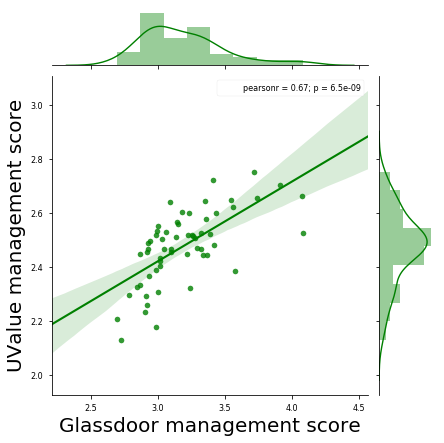

In [99]:
ax=sns.jointplot(x='glassdoor_management', y='UV_management',data= scores_df,color="g",kind="reg")
ax.ax_joint.set_xlabel('Glassdoor management score')
ax.ax_joint.set_ylabel('UValue management score')

Text(28.275,0.5,'UValue salary score')

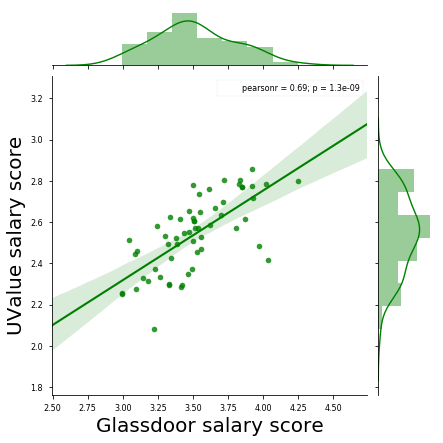

In [97]:
ax=sns.jointplot(x='glassdoor_salary', y='UV_salary',data= scores_df,color="g",kind="reg")
ax.ax_joint.set_xlabel('Glassdoor salary score')
ax.ax_joint.set_ylabel('UValue salary score')

Text(28.275,0.5,'UValue culture score')

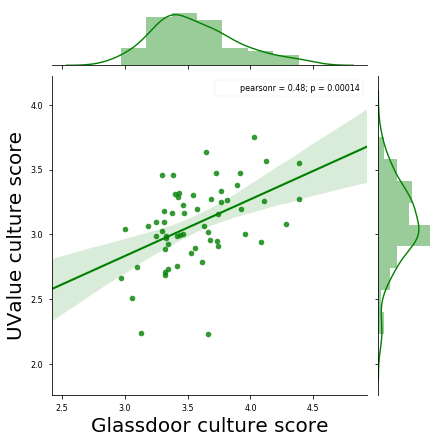

In [98]:
ax=sns.jointplot(x='glassdoor_culture', y='UV_culture',data= scores_df,color="g",kind="reg")
ax.ax_joint.set_xlabel('Glassdoor culture score')
ax.ax_joint.set_ylabel('UValue culture score')